# 將 CH8-量化系統擇時.ipynb 的單股回測系統優化
1. 將一些需要用到的 BaseClass 跟 Implement 搬過來
2. 實作多股回測系統，加入風險控制類別

In [1]:
from alanq.positions import (
    FixedRatioPositionManager,
    RiskBasedPositionManager,
    EqualWeightPositionManager,
    VolatilityBasedPositionManager,
    FixedKellyPositionManager
)
from alanq.backtest import MultiStockBacktester
from alanq.data import StockDataManager
from alanq.factors import BreakoutBuyFactor, BreakdownSellFactor, AtrStopSellFactor
from alanq.performance import PerformanceMetrics

In [2]:
# =========================================================
# 多股票回測範例
# =========================================================
symbols_to_download = ["TSLA", "AAPL", "MSFT"]
start_date = "2020-01-01"
data_manager = StockDataManager(symbols_to_download, start_date=start_date)

stock_data = data_manager.get_stock_data()

print(f"已下載 {len(stock_data)} 檔股票資料")
for symbol, df in stock_data.items():
    print(f"{symbol}: {len(df)} 筆資料，日期範圍 {df.index[0]} 至 {df.index[-1]}")


正在使用 yfinance 下載 3 檔股票資料...
------------------------------
已成功下載 3 檔股票資料
  - TSLA: 1481 筆資料，日期範圍 2020-01-02 至 2025-11-20
  - AAPL: 1481 筆資料，日期範圍 2020-01-02 至 2025-11-20
  - MSFT: 1481 筆資料，日期範圍 2020-01-02 至 2025-11-20
------------------------------
已下載 3 檔股票資料
TSLA: 1481 筆資料，日期範圍 2020-01-02 00:00:00 至 2025-11-20 00:00:00
AAPL: 1481 筆資料，日期範圍 2020-01-02 00:00:00 至 2025-11-20 00:00:00
MSFT: 1481 筆資料，日期範圍 2020-01-02 00:00:00 至 2025-11-20 00:00:00


範例 1：固定比例倉位管理（預設）


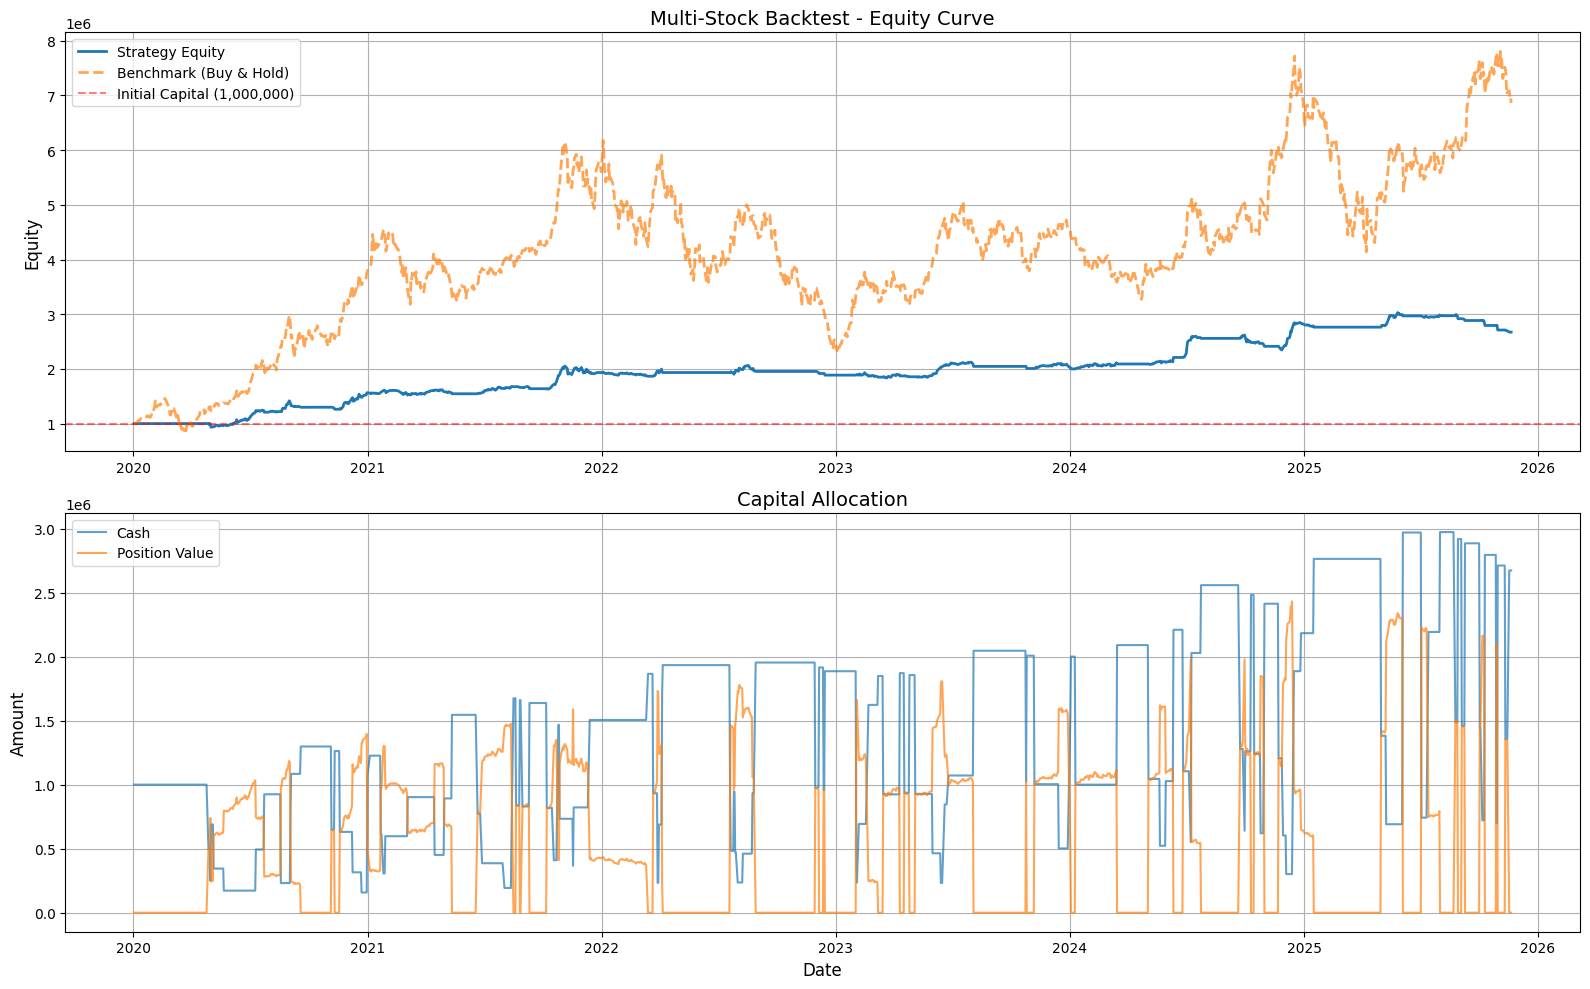

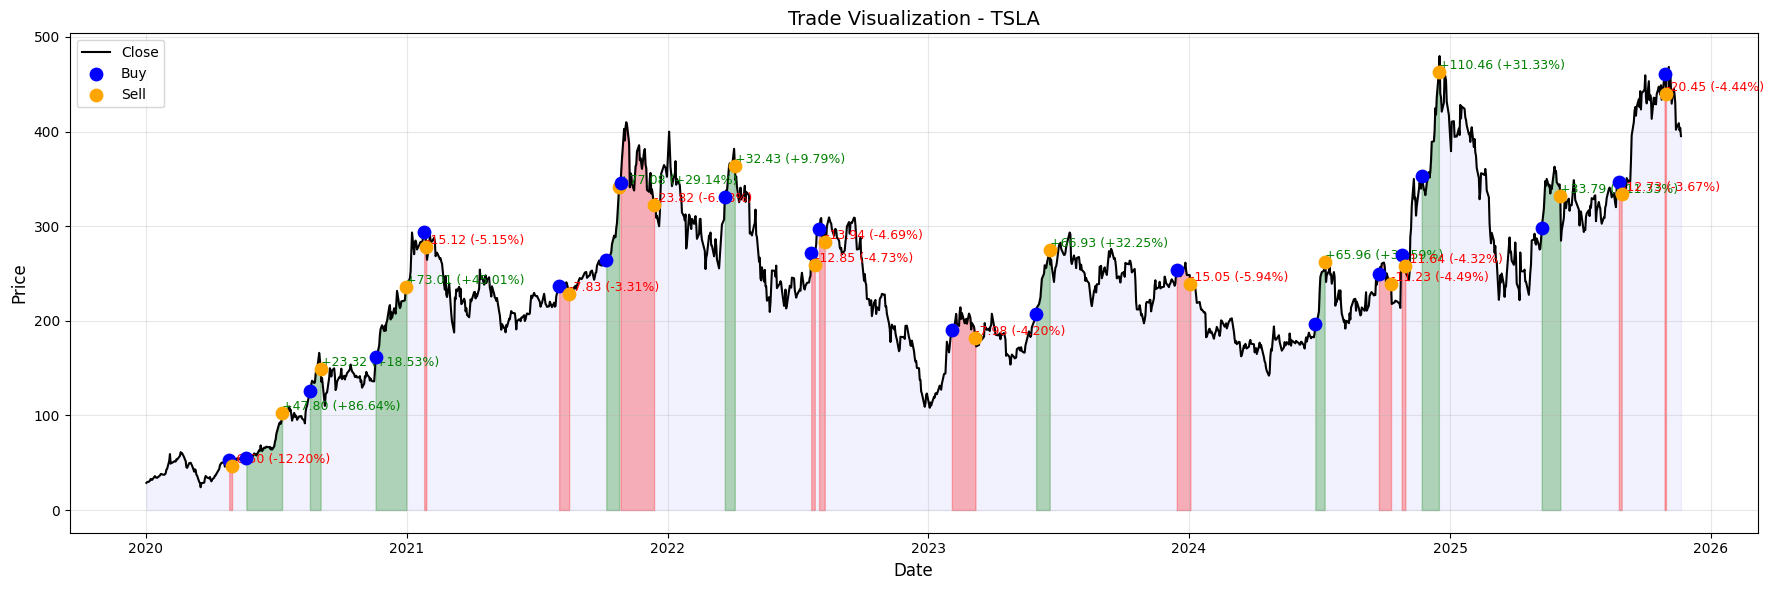

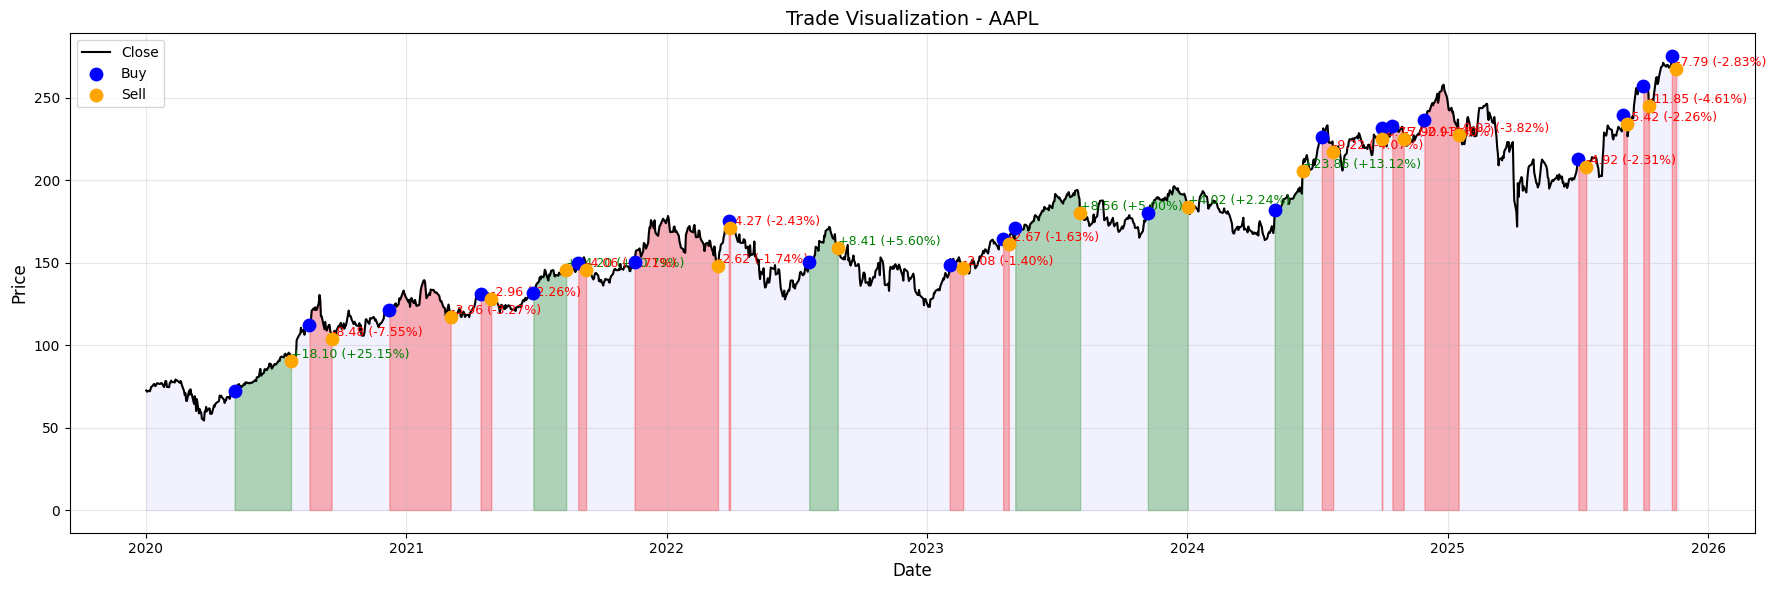

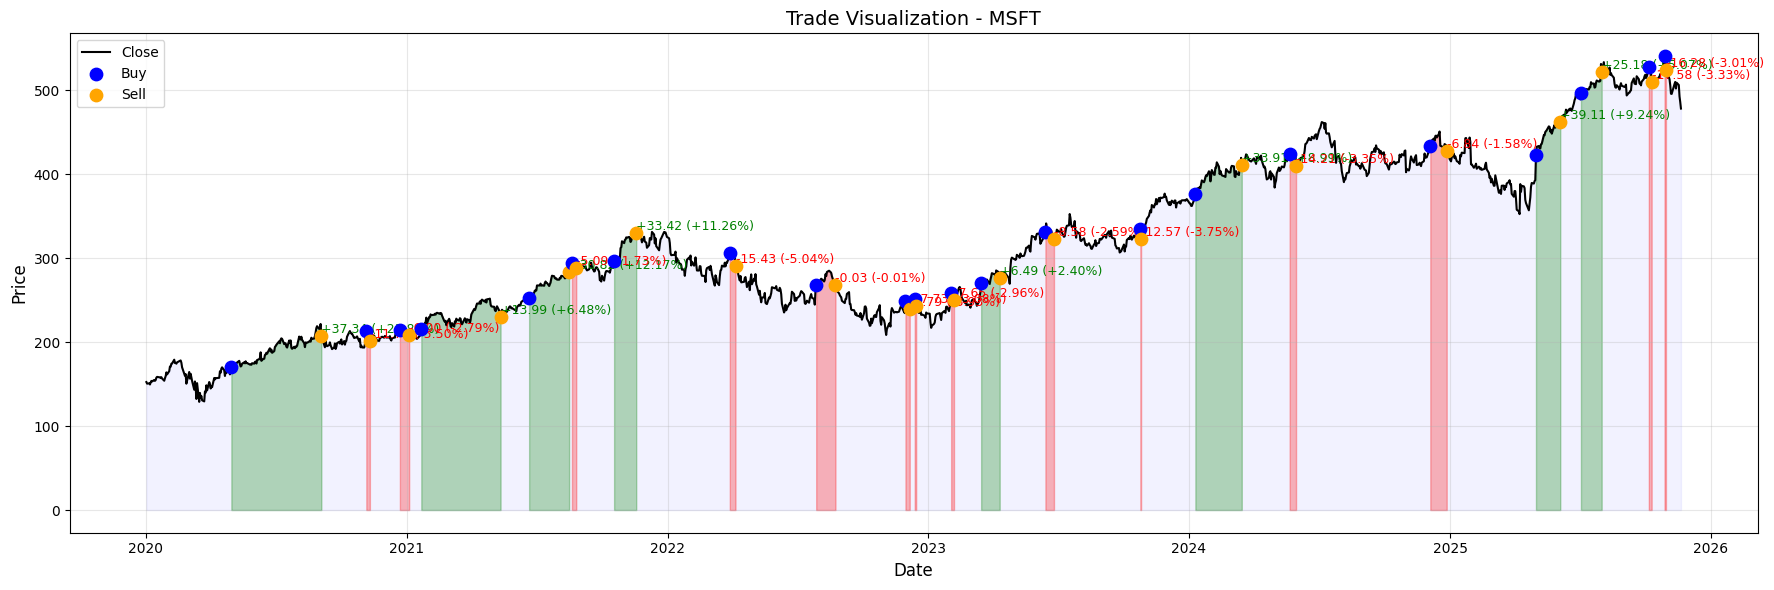


=== 績效指標 ===
策略_總報酬率: 2.6728
策略_年化報酬率: 0.2473
策略_年化波動率: 0.1311
策略_Sharpe: 1.3428
策略_最大回撤: -0.1179
策略_最終權益: 2672849.6876
策略_最終現金: 2672849.6876
基準_總報酬率: 6.8633
基準_年化報酬率: 0.4194
基準_年化波動率: 0.4783
基準_Sharpe: 0.6857
基準_最大回撤: -0.6238

=== 交易紀錄（前 10 筆） ===
  symbol entry_date  exit_date  entry_price  exit_price       shares  \
0   TSLA 2020-04-27 2020-05-01    53.250000   46.754665  9389.671362   
1   TSLA 2020-05-21 2020-07-10    55.173332  102.976669  3122.028863   
2   TSLA 2020-08-18 2020-09-02   125.806000  149.123337  3675.837129   
3   TSLA 2020-11-18 2020-12-31   162.213333  235.223328  3890.462577   
4   TSLA 2021-01-25 2021-01-28   293.600006  278.476654  1044.164411   
5   TSLA 2021-08-02 2021-08-16   236.556671  228.723328   816.521656   
6   TSLA 2021-10-07 2021-10-25   264.536682  341.619995  3095.173836   
7   TSLA 2021-10-27 2021-12-13   345.953339  322.136658  2119.891060   
8   TSLA 2022-03-22 2022-04-05   331.326660  363.753326  2815.010084   
9   TSLA 2022-07-21 2022-07-26

In [3]:
# 範例 1：使用固定比例倉位管理（預設）
print("=" * 60)
print("範例 1：固定比例倉位管理（預設）")
print("=" * 60)

buy_factors = [
    {"class": BreakoutBuyFactor, "xd": 60},
    {"class": BreakoutBuyFactor, "xd": 42},
]

sell_factors = [
    {"class": BreakdownSellFactor, "xd": 120},
    {"class": AtrStopSellFactor, "stop_loss_n": 0.5, "stop_win_n": 3.0}
]

# 使用預設的固定比例倉位管理（50%）
bt1 = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
)

results1, trades1, stats1 = bt1.run(show_plot=True, show_trades_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats1.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n=== 交易紀錄（前 10 筆） ===")
print(trades1.head(10))

print(f"\n總交易次數: {len(trades1)}")
print(f"各股票交易次數:")
print(trades1.groupby('symbol').size())


範例 2：基於風險的倉位管理


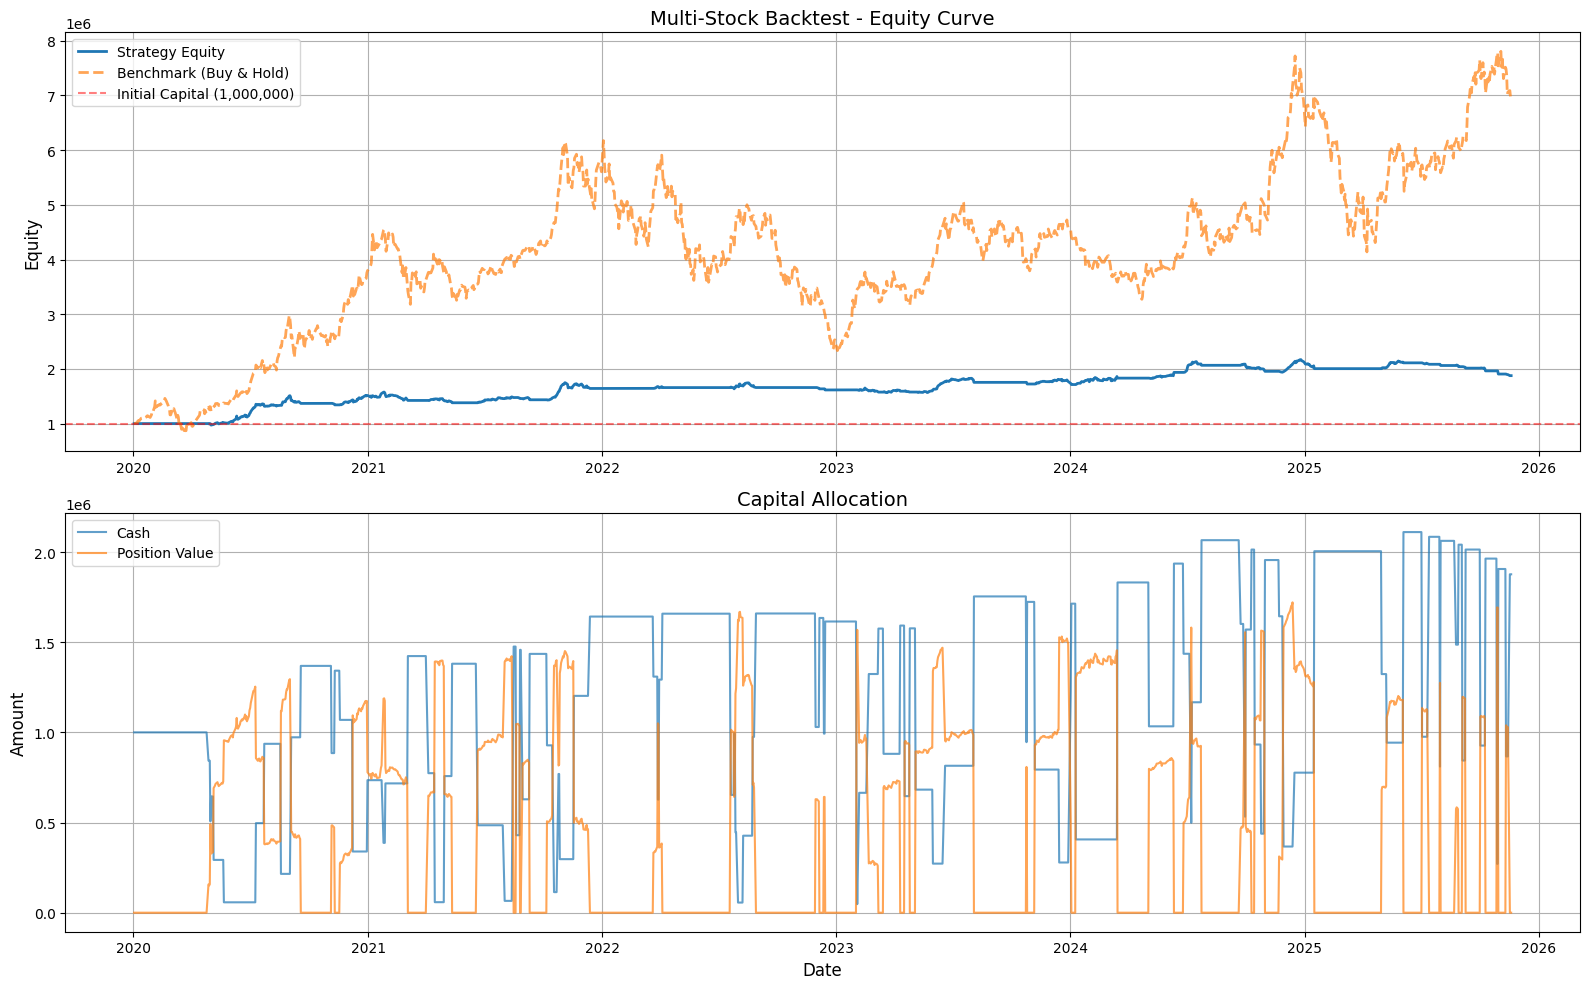


=== 績效指標 ===
策略_總報酬率: 1.8765
策略_年化報酬率: 0.1967
策略_年化波動率: 0.1129
策略_Sharpe: 1.0065
策略_最大回撤: -0.1353
策略_最終權益: 1876540.1150
策略_最終現金: 1876540.1150
基準_總報酬率: 6.9927
基準_年化報酬率: 0.4236
基準_年化波動率: 0.4784
基準_Sharpe: 0.6927
基準_最大回撤: -0.6238

總交易次數: 57


In [8]:
# 範例 2：使用基於風險的倉位管理
print("=" * 60)
print("範例 2：基於風險的倉位管理")
print("=" * 60)

# 建立基於風險的倉位管理器
risk_position_manager = RiskBasedPositionManager(
    risk_per_trade=0.02,  # 每筆交易風險 2%
    atr_multiplier=2.0,   # ATR 倍數
    max_position_ratio=1.0  # 最大持倉比例 100%
)

bt2 = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
    position_manager=risk_position_manager  # 傳入自訂倉位管理器
)

results2, trades2, stats2 = bt2.run(show_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats2.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n總交易次數: {len(trades2)}")


範例 3：等權重倉位管理


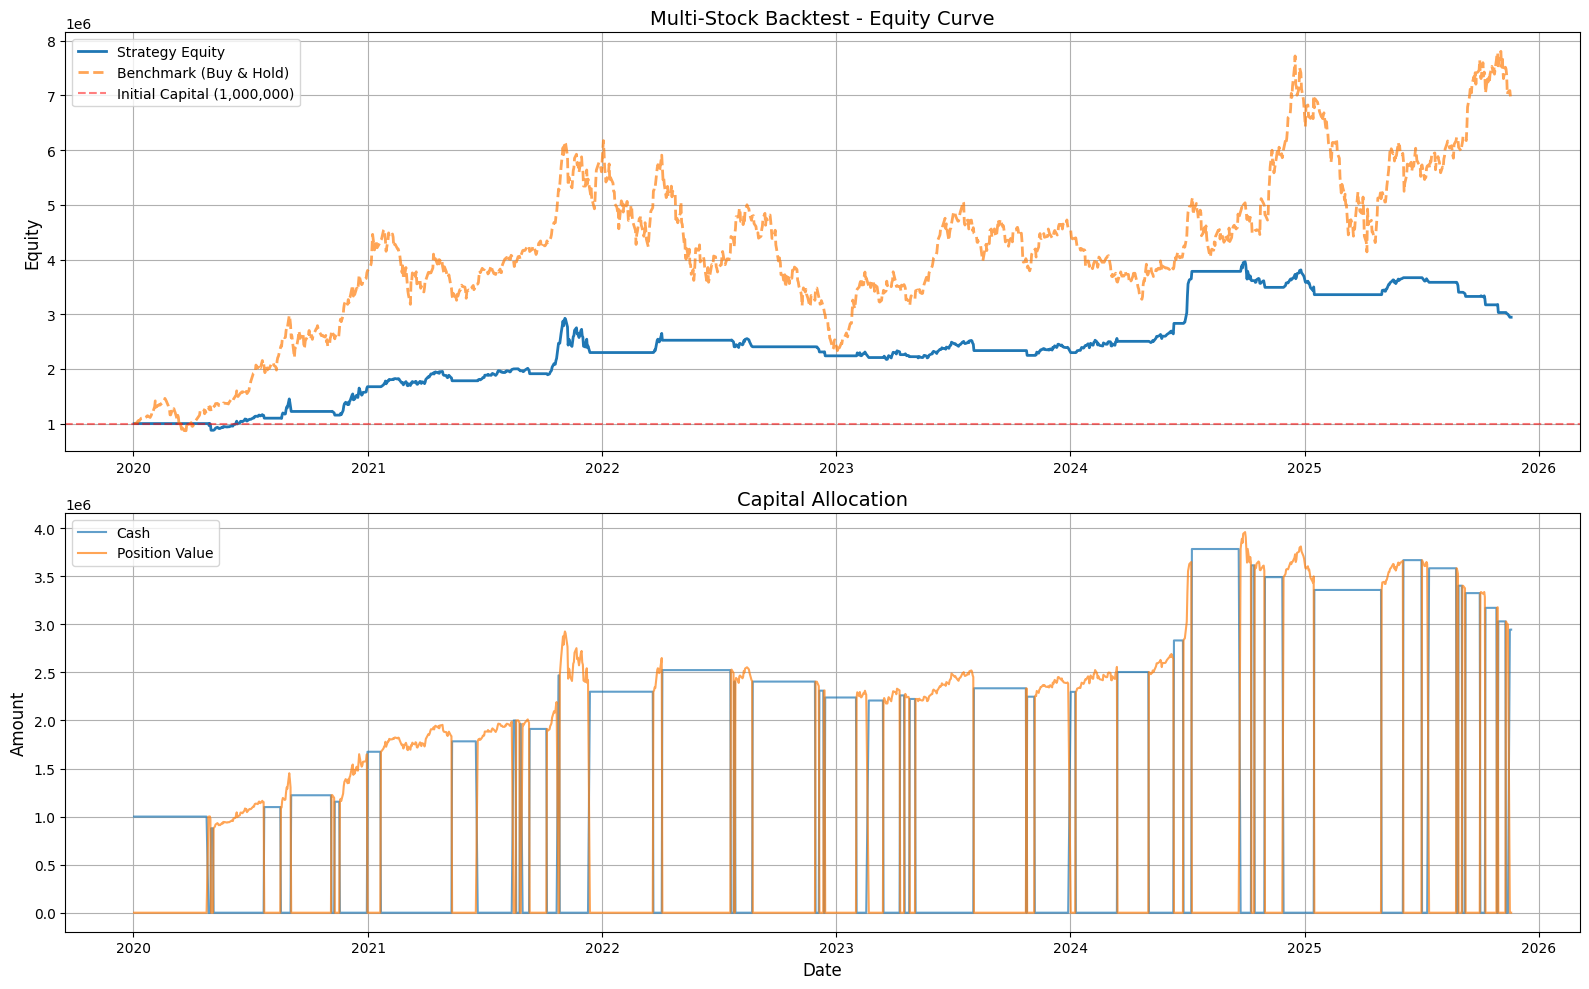


=== 績效指標 ===
策略_總報酬率: 2.9450
策略_年化報酬率: 0.2627
策略_年化波動率: 0.2286
策略_Sharpe: 0.9187
策略_最大回撤: -0.2564
策略_最終權益: 2945021.7678
策略_最終現金: 2945021.7678
基準_總報酬率: 6.9927
基準_年化報酬率: 0.4236
基準_年化波動率: 0.4784
基準_Sharpe: 0.6927
基準_最大回撤: -0.6238

總交易次數: 37

各股票交易次數:
symbol
AAPL    13
MSFT    13
TSLA    11
dtype: int64


In [9]:
# 範例 3：使用等權重倉位管理
print("=" * 60)
print("範例 3：等權重倉位管理")
print("=" * 60)

# 建立等權重倉位管理器
equal_weight_manager = EqualWeightPositionManager(
    max_stocks=3  # 最多同時持有 3 檔股票
)

bt3 = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
    position_manager=equal_weight_manager
)

results3, trades3, stats3 = bt3.run(show_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats3.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n總交易次數: {len(trades3)}")
print(f"\n各股票交易次數:")
print(trades3.groupby('symbol').size())


範例：使用 Fixed Kelly 倉位管理
--- Fixed Kelly PM Initialized ---
Win Rate (p): 0.5500, Odds Ratio (r): 1.2000
Calculated Kelly Ratio (f): 0.0875
----------------------------------


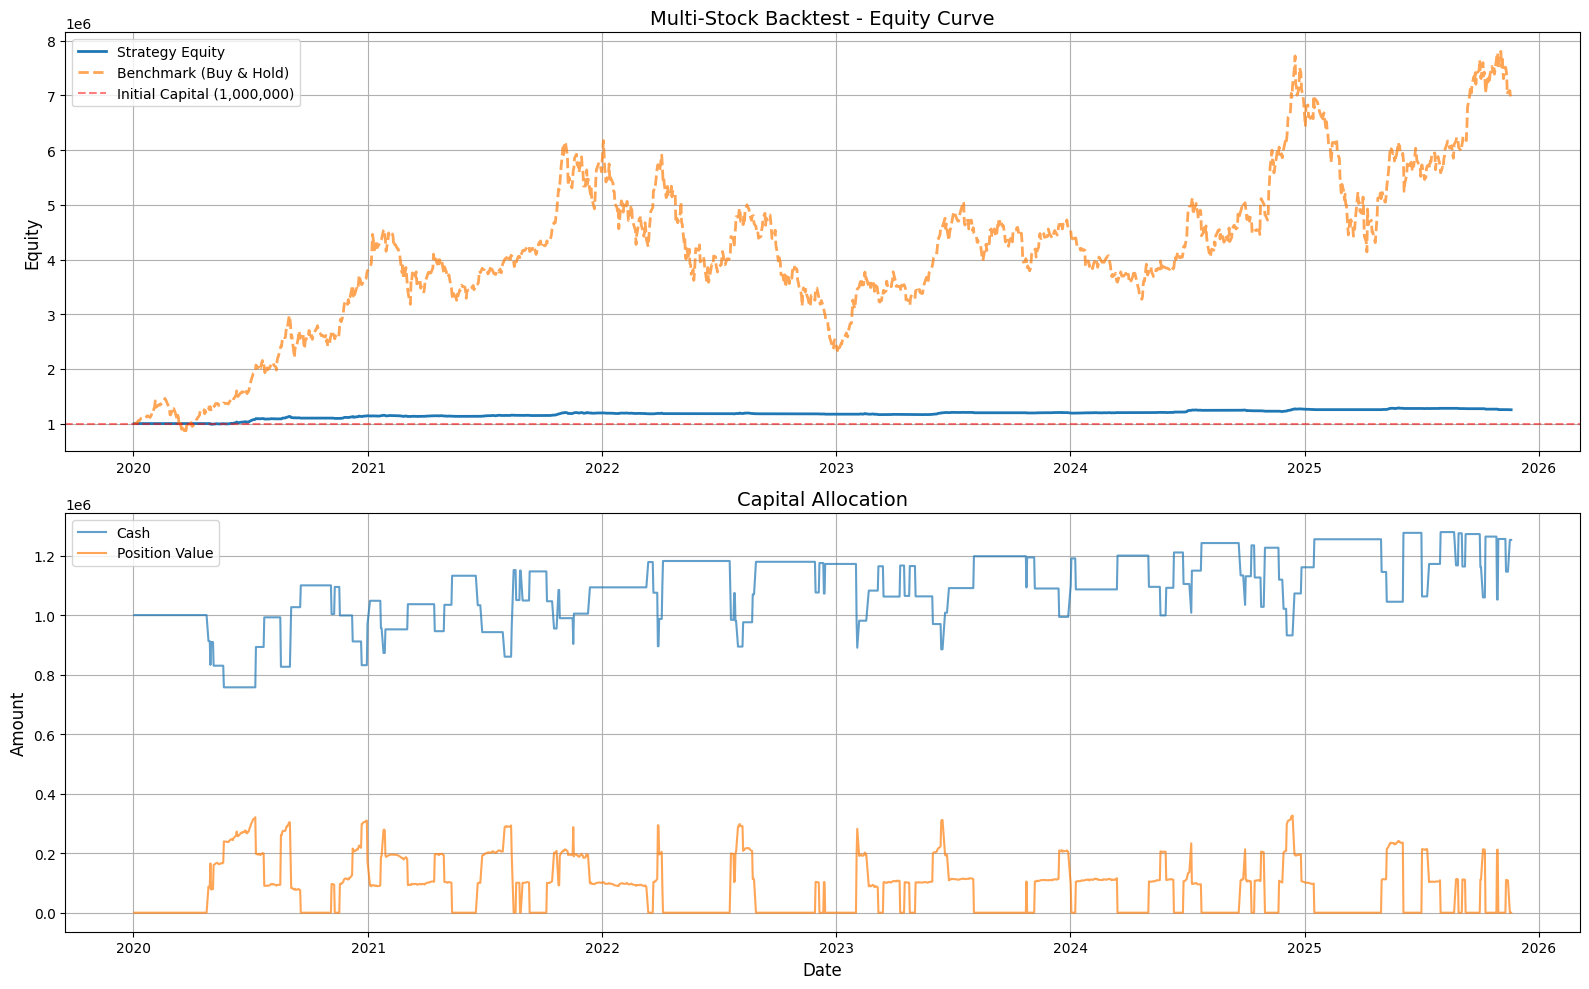


=== 績效指標 ===
策略_總報酬率: 1.2527
策略_年化報酬率: 0.1480
策略_年化波動率: 0.0324
策略_Sharpe: 1.2020
策略_最大回撤: -0.0334
策略_最終權益: 1252652.7370
策略_最終現金: 1252652.7370
基準_總報酬率: 6.9927
基準_年化報酬率: 0.4236
基準_年化波動率: 0.4784
基準_Sharpe: 0.6927
基準_最大回撤: -0.6238

總交易次數: 65

各股票交易次數:
symbol
AAPL    22
MSFT    22
TSLA    21
dtype: int64


In [10]:
# 範例 4：Kelly公式的倉位管理

print("=" * 60)
print("範例：使用 Fixed Kelly 倉位管理")
print("=" * 60)

# 1. 建立 Fixed Kelly 倉位管理器
# 假設策略的預估參數為 p=0.55, r=1.2 (約產生 4.5% 的 Kelly 比例)
fixed_kelly_manager = FixedKellyPositionManager(
    win_rate=0.55, 
    odds_ratio=1.2, 
    full_kelly_ratio=0.5,  # 使用保守的半 Kelly 投入 (50%)
    max_position_ratio=1.0 # 最大倉位 100%
)

# FixedKellyPositionManager 在初始化時會打印計算出的 Kelly 比例

bt_kelly = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
    position_manager=fixed_kelly_manager
)

# 執行回測並繪圖
# 假設 bt_kelly.run() 會返回 results, trades, stats
results_kelly, trades_kelly, stats_kelly = bt_kelly.run(show_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats_kelly.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n總交易次數: {len(trades_kelly)}")
print(f"\n各股票交易次數:")
print(trades_kelly.groupby('symbol').size())

範例 4：比較不同倉位管理策略
--- Fixed Kelly PM Initialized ---
Win Rate (p): 0.5500, Odds Ratio (r): 1.2000
Calculated Kelly Ratio (f): 0.0875
----------------------------------

=== 倉位管理策略比較 ===
           策略名稱   策略總報酬率  策略年化報酬率  策略Sharpe    策略最大回撤  策略交易次數       策略最終權益   基準總報酬率  基準年化報酬率  基準Sharpe    基準最大回撤
fix ratio (50%) 2.672851 0.247408  1.343229 -0.117932      65 2.672851e+06 6.992733  0.42361  0.692714 -0.623781
fix ratio (30%) 1.930909 0.200482  1.291877 -0.081050      65 1.930909e+06 6.992733  0.42361  0.692714 -0.623781
     risk based 1.876540 0.196668  1.006521 -0.135252      57 1.876540e+06 6.992733  0.42361  0.692714 -0.623781
   equal weight 2.945022 0.262653  0.918667 -0.256379      37 2.945022e+06 6.992733  0.42361  0.692714 -0.623781
    Fixed Kelly 1.252653 0.147973  1.201983 -0.033412      65 1.252653e+06 6.992733  0.42361  0.692714 -0.623781


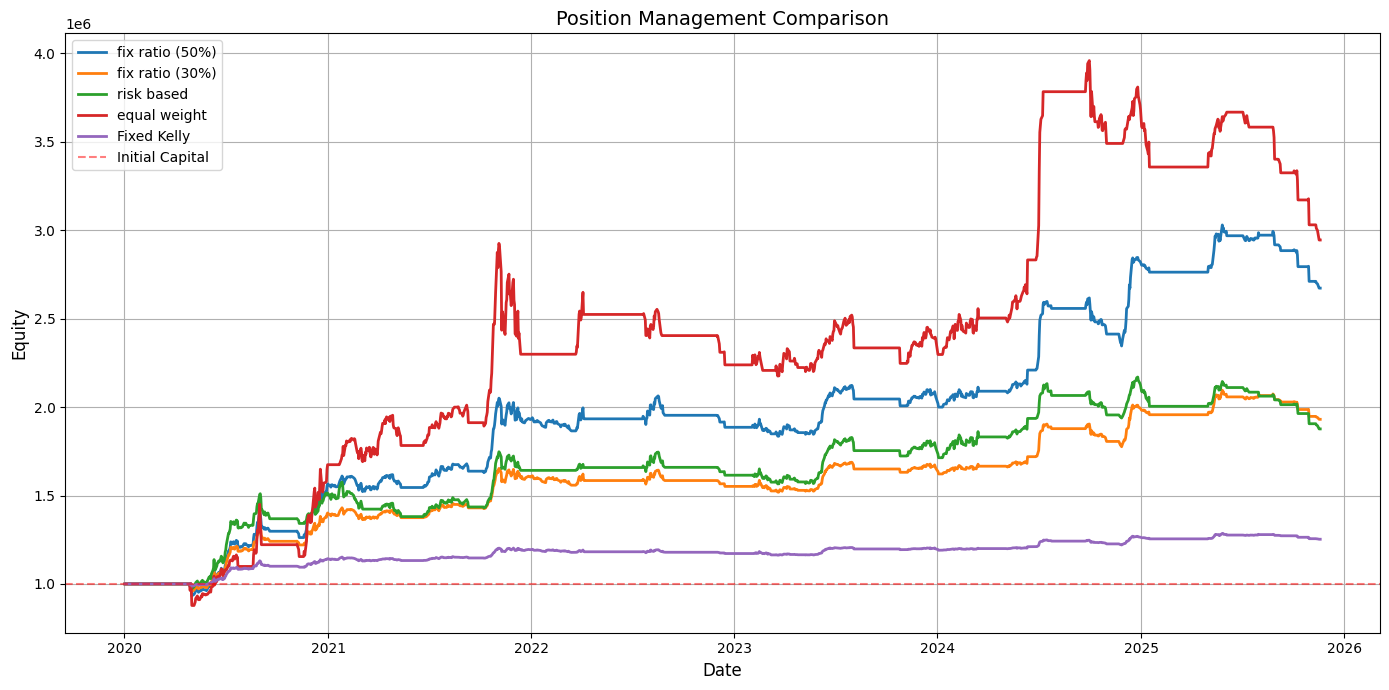

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 範例 5：比較不同倉位管理策略
print("=" * 60)
print("範例 4：比較不同倉位管理策略")
print("=" * 60)

# 定義不同的倉位管理策略
position_managers = {
    "fix ratio (50%)": FixedRatioPositionManager(position_ratio=0.5),
    "fix ratio (30%)": FixedRatioPositionManager(position_ratio=0.3),
    "risk based": RiskBasedPositionManager(risk_per_trade=0.02, atr_multiplier=2.0),
    "equal weight": EqualWeightPositionManager(max_stocks=3),
    "Fixed Kelly": FixedKellyPositionManager(win_rate=0.55, odds_ratio=1.2, full_kelly_ratio=0.5, max_position_ratio=1.0)
}

comparison_results = []

for name, pm in position_managers.items():
    bt = MultiStockBacktester(
        stock_data=stock_data,
        buy_factors=buy_factors,
        sell_factors=sell_factors,
        initial_capital=1_000_000,
        position_manager=pm
    )
    
    results, trades, stats = bt.run(show_plot=False)
    
    comparison_results.append({
        "策略名稱": name,
        "策略總報酬率": stats["策略_總報酬率"],
        "策略年化報酬率": stats["策略_年化報酬率"],
        "策略Sharpe": stats["策略_Sharpe"],
        "策略最大回撤": stats["策略_最大回撤"],
        "策略交易次數": len(trades),
        "策略最終權益": stats["策略_最終權益"],
        "基準總報酬率": stats["基準_總報酬率"],
        "基準年化報酬率": stats["基準_年化報酬率"],
        "基準Sharpe": stats["基準_Sharpe"],
        "基準最大回撤": stats["基準_最大回撤"],
    })

comparison_df = pd.DataFrame(comparison_results)
print("\n=== 倉位管理策略比較 ===")
print(comparison_df.to_string(index=False))

# 繪製權益曲線比較
fig, ax = plt.subplots(figsize=(14, 7))

for name, pm in position_managers.items():
    bt = MultiStockBacktester(
        stock_data=stock_data,
        buy_factors=buy_factors,
        sell_factors=sell_factors,
        initial_capital=1_000_000,
        position_manager=pm
    )
    results, trades, stats = bt.run(show_plot=False)
    ax.plot(results['equity_curve'].index, 
            results['equity_curve'].values, 
            label=name, linewidth=2)

ax.axhline(y=1_000_000, color='r', linestyle='--', alpha=0.5, label='Initial Capital')
ax.set_title('Position Management Comparison', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Equity', fontsize=12)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


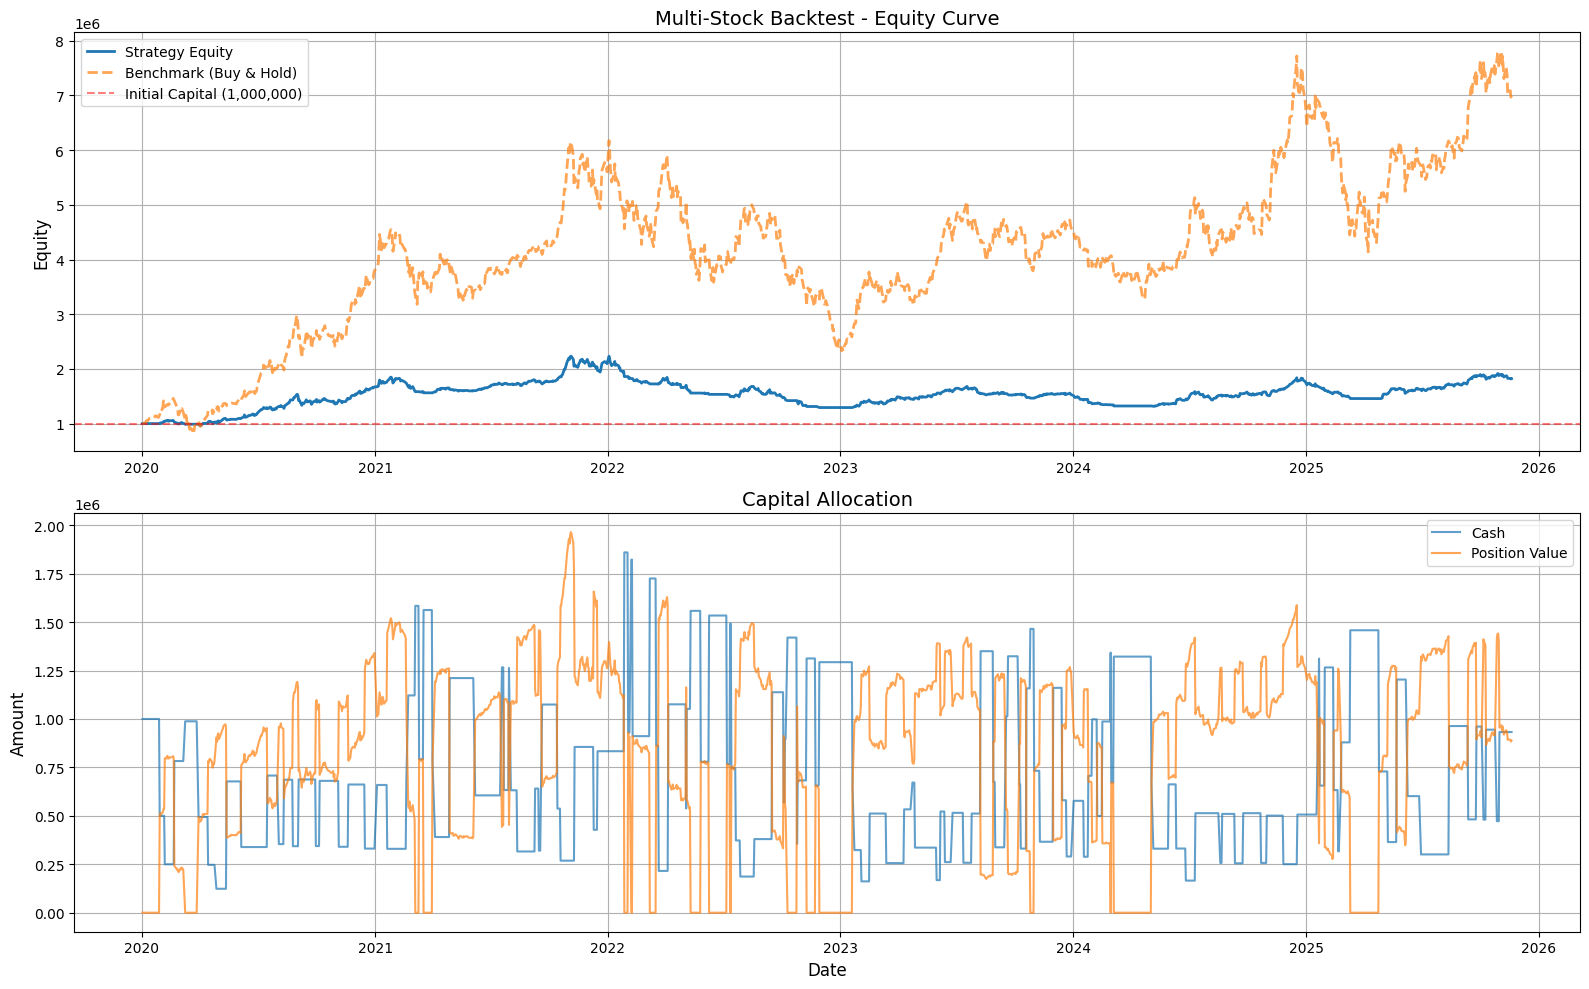


=== 績效指標 ===
策略_總報酬率: 1.8209
策略_年化報酬率: 0.1927
策略_年化波動率: 0.1835
策略_Sharpe: 0.6486
策略_最大回撤: -0.4210
策略_最終權益: 1820920.4112
策略_最終現金: 932586.0448
基準_總報酬率: 6.9927
基準_年化報酬率: 0.4236
基準_年化波動率: 0.4784
基準_Sharpe: 0.6927
基準_最大回撤: -0.6238

總交易次數: 75

各股票交易次數:
symbol
AAPL    15
MSFT    51
TSLA     9
dtype: int64


In [17]:
# 範例6：多股票不同因子進行擇時
# 針對 TSLA 的策略
buy_factors_tsla = [{'xd': 42, 'class': BreakoutBuyFactor}]
sell_factors_tsla = [{'xd': 60, 'class': BreakdownSellFactor}]

# 針對 AAPL 的策略
buy_factors_aapl = [{'xd': 21, 'class': BreakoutBuyFactor}]
sell_factors_aapl = [{'xd': 42, 'class': BreakdownSellFactor}]

# 針對 MSFT 的策略
buy_factors_msft = [{'xd': 14, 'class': BreakoutBuyFactor}]
sell_factors_msft = [{'xd': 7, 'class': BreakdownSellFactor}]

# 建立客製化策略dict，股票用不同策略
factor_dict = {
    'TSLA': {
        'buy_factors': buy_factors_tsla,
        'sell_factors': sell_factors_tsla
    },
    'AAPL': {
        'buy_factors': buy_factors_aapl,
        'sell_factors': sell_factors_aapl
    },
    'MSFT': {
        'buy_factors': buy_factors_msft,
        'sell_factors': sell_factors_msft
    }
}

# 執行回測時，將 factor_dict 傳入 strategy_config
bt_multi_stock_strategy = MultiStockBacktester(
    stock_data=stock_data, 
    strategy_config=factor_dict, # 傳入客製化配置
    initial_capital=1_000_000
)

results, trades, stats = bt_multi_stock_strategy.run(show_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n總交易次數: {len(trades)}")
print(f"\n各股票交易次數:")
print(trades.groupby('symbol').size())

In [18]:
# 透過交叉表驗證各股票是否都用各自的策略執行
pd.crosstab(trades.symbol, trades.buy_factor)

buy_factor,BreakoutBuyFactor_{'xd': 14};,BreakoutBuyFactor_{'xd': 21};,BreakoutBuyFactor_{'xd': 42};
symbol,,,
AAPL,0,15,0
MSFT,51,0,0
TSLA,0,0,9


Method 1: Display Full Summary
Performance Summary

[Basic Performance Metrics]

[Trade Statistics]
  Total Trades        :         75
  Winning Trades      :         34
  Losing Trades       :         41
  Breakeven Trades    :          0
  Win Rate            :     0.4533 ( 45.33%)
  Avg Profit          :  59,253.79
  Avg Loss            :  29,114.84
  Profit/Loss Ratio   :       2.04
  Total Profit        : 2,014,628.73
  Total Loss          : 1,193,708.32
  Net Profit          : 820,920.41
  Max Single Profit   : 338,745.16
  Max Single Loss     : -162,234.50
  Avg Holding Days    :       49.7 days
  Avg Return          :     0.0587 (  5.87%)
  Max Consecutive Wins:          4
  Max Consecutive Losses:          9


Performance by Symbol


[TSLA]
  Total Trades: 9
  Winning: 5, Losing: 4
  Win Rate: 55.56%
  Total P&L: 323,191.16
  Avg Return: 33.56%
  Avg Holding Days: 146.3 days

[AAPL]
  Total Trades: 15
  Winning: 7, Losing: 8
  Win Rate: 46.67%
  Total P&L: 338,378.04
  Avg Ret

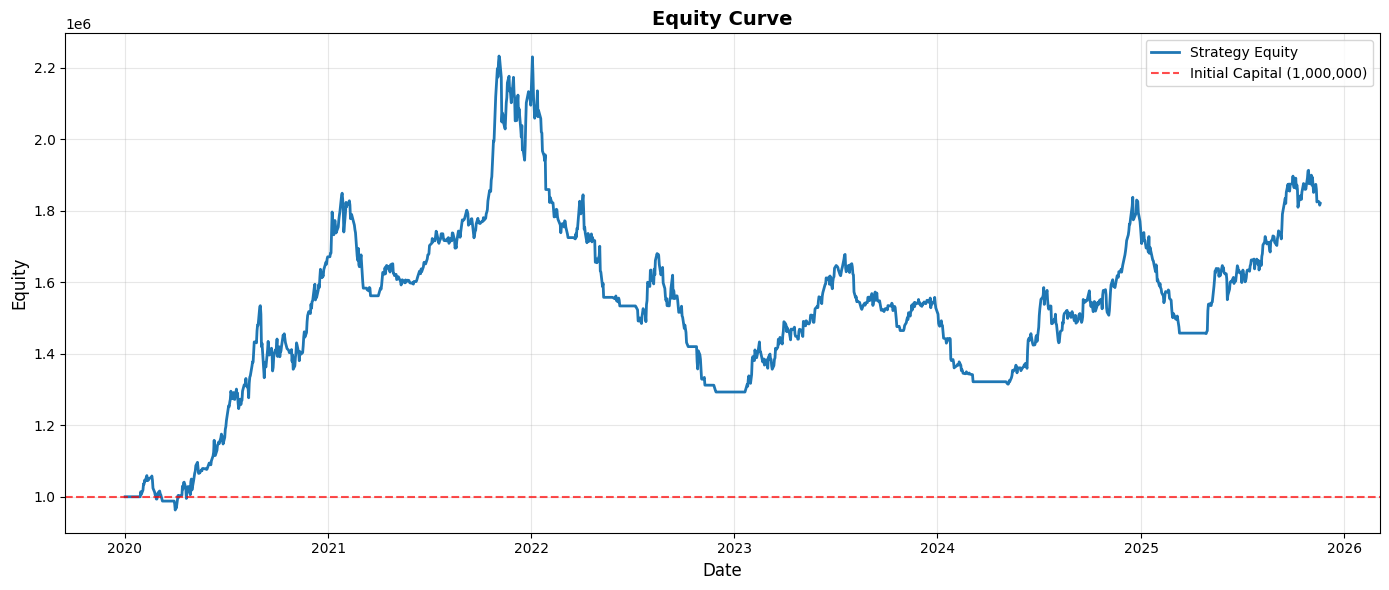


Plotting drawdown curve...


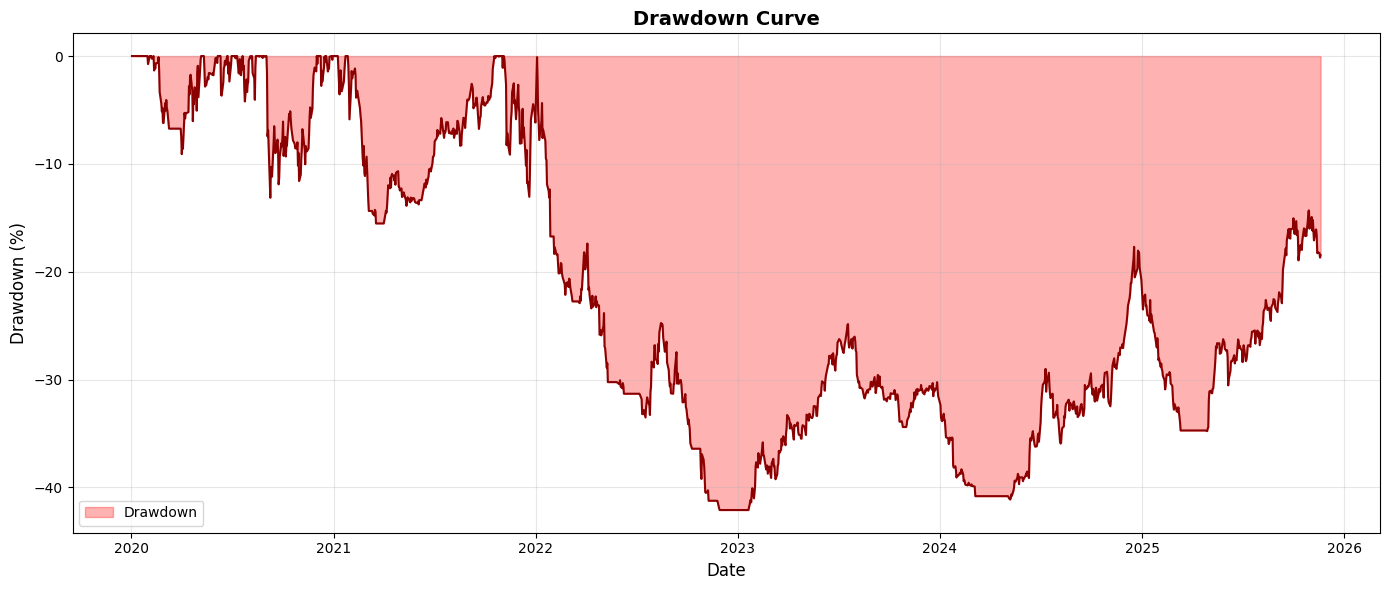


Plotting trade distribution...


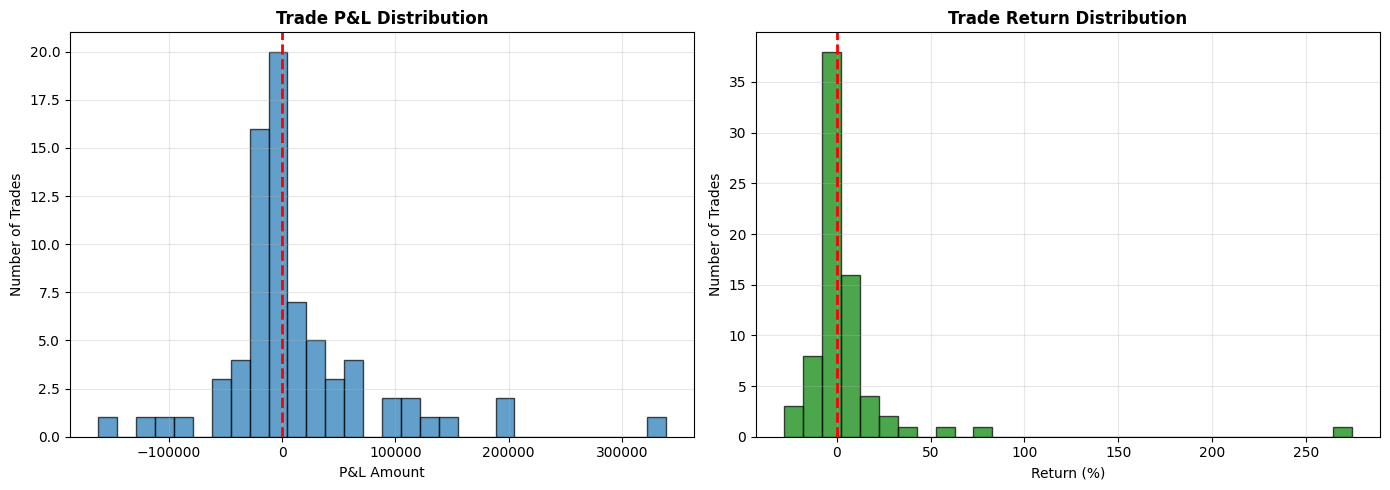


Plotting monthly returns...


/Users/alan/q-trade/alanq/performance/performance_metrics.py:376: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_equity = self.equity_curve.resample('M').last()


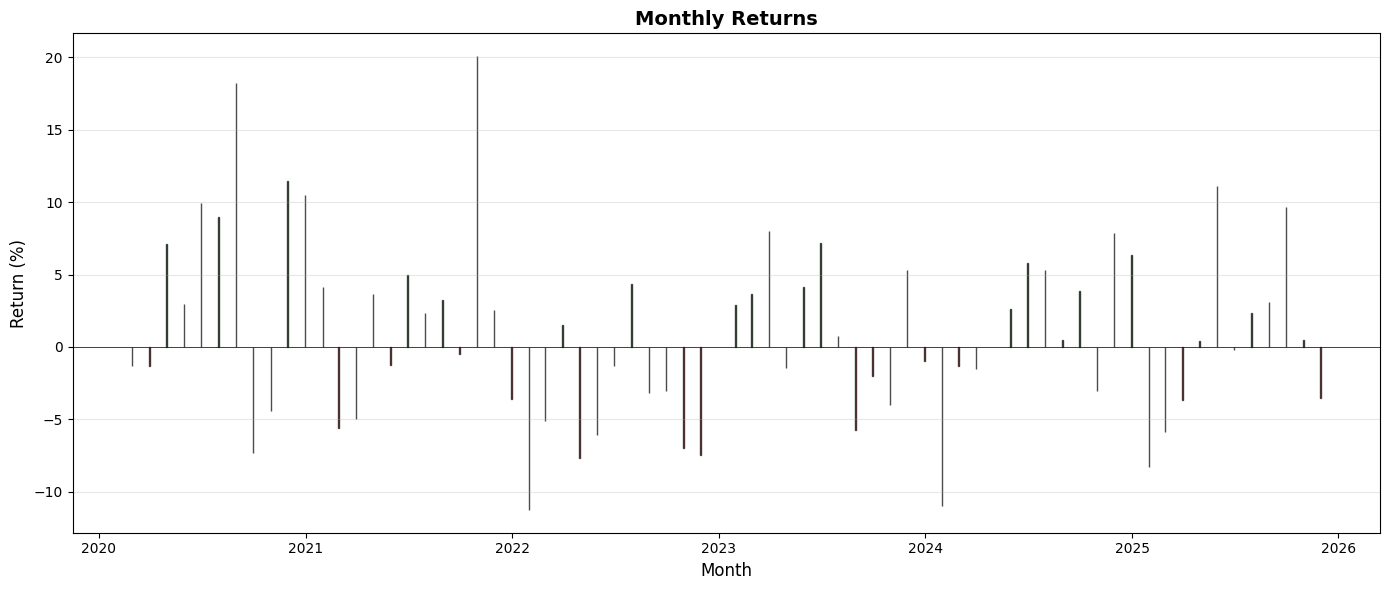


All metrics DataFrame:
                     數值
策略_總報酬率    1.820920e+00
策略_年化報酬率   1.927046e-01
策略_年化波動率   1.834644e-01
策略_Sharpe  6.485690e-01
策略_最大回撤   -4.209681e-01
策略_最終權益    1.820920e+06
策略_最終現金    9.325860e+05
基準_總報酬率    6.992733e+00
基準_年化報酬率   4.236098e-01
基準_年化波動率   4.783759e-01
基準_Sharpe  6.927140e-01
基準_最大回撤   -6.237812e-01
總交易次數      7.500000e+01
獲利交易次數     3.400000e+01
虧損交易次數     4.100000e+01
持平交易次數     0.000000e+00
勝率         4.533333e-01
平均獲利       5.925379e+04
平均虧損       2.911484e+04
盈虧比        2.035175e+00
總獲利        2.014629e+06
總虧損        1.193708e+06
淨獲利        8.209204e+05
最大單筆獲利     3.387452e+05
最大單筆虧損    -1.622345e+05
平均持倉天數     4.972000e+01
平均報酬率      5.871413e-02
最大連續獲利次數   4.000000e+00
最大連續虧損次數   9.000000e+00


In [19]:
# 使用範例：展示交易績效指標

# 使用之前的回測結果
# 建立績效指標物件
metrics = PerformanceMetrics(
    trades=trades,
    stats=stats,
    equity_curve=results['equity_curve'],
    initial_capital=1_000_000
)

# 方法 1：顯示完整摘要
print("=" * 80)
print("Method 1: Display Full Summary")
print("=" * 80)
metrics.show_summary()

# 方法 2：按股票分組顯示
print("\n")
metrics.show_by_symbol()

# 方法 3：繪製各種圖表
print("\nPlotting equity curve...")
metrics.plot_equity_curve()

print("\nPlotting drawdown curve...")
metrics.plot_drawdown()

print("\nPlotting trade distribution...")
metrics.plot_trade_distribution()

print("\nPlotting monthly returns...")
metrics.plot_monthly_returns()

# 方法 4：取得所有指標的 DataFrame
print("\nAll metrics DataFrame:")
metrics_df = metrics.get_metrics_dataframe()
print(metrics_df)

# 方法 5：一次顯示所有內容（取消註解以執行）
# metrics.show_all()


In [ ]:
# metrics_df 裡面有所有指標跟數值
metrics_df

,數值
總報酬率,1.820921e+00
年化報酬率,1.927047e-01
年化波動率,1.834643e-01
Sharpe,6.485695e-01
最大回撤,-4.209680e-01
最終權益,1.820921e+06
最終現金,9.325865e+05
總交易次數,7.500000e+01
獲利交易次數,3.400000e+01
虧損交易次數,4.100000e+01
